In [1]:
import os
import re
import shutil
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models,transforms,datasets
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.model_selection import KFold
import itertools

/var/folders/kk/6q2jd0hj56z_vzsn0nsr_bf40000gn/T/ipykernel_8267/144049616.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Use available device

In [2]:
device = "cpu"
if torch.cuda.is_available():
    print("using gpu")
    device = torch.device("gpu")
elif torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")

using mps


## Data loader

In [3]:
resized_images = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [5]:
data_dir = '../Data/brain_tumor/brain_tumor_dataset/'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=resized_images) for x in ['train', 'test']}

In [6]:
train_loader = torch.utils.data.DataLoader(dsets['train'], batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dsets['test'], batch_size=8, shuffle=False, num_workers=2)

## Training and test functions

In [7]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1,verbose=True):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs): #tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        if verbose:
            print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [8]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        bs = labels.size(0)

        output = model.forward(inputs)
        loss = loss_fn(output, labels)

        pred = output.max(1, keepdim=True)[1]
        running_loss += loss
        running_corrects += pred.eq(labels.view_as(pred)).sum()

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [9]:
def train_and_test(model,data_loader_train, data_loader_test,loss_fn,optimizer,n_epochs=1):
    model = model.to(device)
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    loss_test = np.zeros(n_epochs)
    acc_test = np.zeros(n_epochs)
    
    for epoch_num in tqdm(range(n_epochs)):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_train:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)
            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader_test:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            bs = labels.size(0)

            output = model.forward(inputs)
            loss = loss_fn(output, labels)

            pred = output.max(1, keepdim=True)[1]
            running_loss += loss
            running_corrects += pred.eq(labels.view_as(pred)).sum()

            size += bs

        print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))
        loss_test[epoch_num] = running_loss / size
        acc_test[epoch_num] = running_corrects.item() / size
        
    return loss_train, acc_train, loss_test, acc_test

In [10]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    labels_all = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    
    return labels_all, predictions

In [11]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (4, 4))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [12]:
def evaluation_plots(model, test_loader, loss_train, acc_train, loss_test, acc_test):
    plt.plot(np.arange(1,len(loss_train)+1), loss_train, label='Loss train')
    plt.plot(np.arange(1,len(loss_test)+1), loss_test, label='Loss test')
    plt.legend()
    plt.title('Loss according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(np.arange(1,len(loss_train)+1), np.log(loss_train), label='Loss train')
    plt.plot(np.arange(1,len(loss_test)+1), np.log(loss_test), label='Loss test')
    plt.legend()
    plt.title('Log loss according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.show()
    
    plt.plot(np.arange(1,len(acc_train)+1), acc_train, label='Train accuracy')
    plt.plot(np.arange(1,len(acc_test)+1), acc_test, label='Test accuracy')
    plt.legend()
    plt.title('Accuracy according to the number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    labels, predictions = predict(model,test_loader)

    target_names = ['yes','no']

    cm = confusion_matrix(labels, predictions)
    plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

    print(classification_report(labels, predictions, target_names= target_names))

## EfficientNet

### EfficientNet b7

Best accuracy, the more complex

In [13]:
model_eff_net7 = models.efficientnet_b7(weights='DEFAULT')

In [14]:
model_eff_net7 = model_eff_net7.to(device)

In [15]:
print(model_eff_net7)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [16]:
for param in model_eff_net7.parameters():
    param.requires_grad = False

model_eff_net7.classifier._modules['1'] = nn.Linear(2560, 2)
model_eff_net7.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [17]:
print(model_eff_net7)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [18]:
model_eff_net7 = model_eff_net7.to(device)

In [19]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net7.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net7, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 0.1865 Acc: 0.7202


  3%|▎         | 1/30 [00:31<15:16, 31.62s/it]

Test - Loss: 0.3567 Acc: 0.5765
Train - Loss: 0.1555 Acc: 0.7440


  7%|▋         | 2/30 [01:00<13:59, 29.98s/it]

Test - Loss: 0.3630 Acc: 0.5529
Train - Loss: 0.1390 Acc: 0.7798


 10%|█         | 3/30 [01:29<13:16, 29.49s/it]

Test - Loss: 0.4748 Acc: 0.5412
Train - Loss: 0.0974 Acc: 0.8274


 13%|█▎        | 4/30 [01:58<12:40, 29.26s/it]

Test - Loss: 0.4679 Acc: 0.5294
Train - Loss: 0.1025 Acc: 0.8274


 17%|█▋        | 5/30 [02:27<12:08, 29.12s/it]

Test - Loss: 0.4019 Acc: 0.5765
Train - Loss: 0.0754 Acc: 0.8750


 20%|██        | 6/30 [02:55<11:35, 28.97s/it]

Test - Loss: 0.4375 Acc: 0.5059
Train - Loss: 0.0713 Acc: 0.8631


 23%|██▎       | 7/30 [03:24<11:04, 28.91s/it]

Test - Loss: 0.4484 Acc: 0.5765
Train - Loss: 0.0691 Acc: 0.8929


 27%|██▋       | 8/30 [03:53<10:34, 28.86s/it]

Test - Loss: 0.4687 Acc: 0.5529
Train - Loss: 0.0770 Acc: 0.8571


 30%|███       | 9/30 [04:22<10:06, 28.88s/it]

Test - Loss: 0.4097 Acc: 0.5882
Train - Loss: 0.0686 Acc: 0.8631


 33%|███▎      | 10/30 [04:50<09:35, 28.76s/it]

Test - Loss: 0.4330 Acc: 0.5294
Train - Loss: 0.0462 Acc: 0.9107


 37%|███▋      | 11/30 [05:19<09:05, 28.73s/it]

Test - Loss: 0.4620 Acc: 0.5059
Train - Loss: 0.0724 Acc: 0.8750


 40%|████      | 12/30 [05:47<08:34, 28.58s/it]

Test - Loss: 0.4080 Acc: 0.5882
Train - Loss: 0.0774 Acc: 0.8750


 43%|████▎     | 13/30 [06:15<08:04, 28.48s/it]

Test - Loss: 0.3791 Acc: 0.5882
Train - Loss: 0.0798 Acc: 0.8512


 47%|████▋     | 14/30 [06:44<07:34, 28.42s/it]

Test - Loss: 0.3573 Acc: 0.5882
Train - Loss: 0.0791 Acc: 0.8631


 50%|█████     | 15/30 [07:12<07:05, 28.38s/it]

Test - Loss: 0.4019 Acc: 0.5765
Train - Loss: 0.1101 Acc: 0.8333


 53%|█████▎    | 16/30 [07:40<06:36, 28.35s/it]

Test - Loss: 0.4183 Acc: 0.5647
Train - Loss: 0.0766 Acc: 0.8631


 57%|█████▋    | 17/30 [08:09<06:08, 28.33s/it]

Test - Loss: 0.4864 Acc: 0.5647
Train - Loss: 0.0831 Acc: 0.8869


 60%|██████    | 18/30 [08:37<05:39, 28.32s/it]

Test - Loss: 0.5911 Acc: 0.5059
Train - Loss: 0.1091 Acc: 0.8333


 63%|██████▎   | 19/30 [09:05<05:11, 28.27s/it]

Test - Loss: 0.4705 Acc: 0.6000
Train - Loss: 0.1079 Acc: 0.8512


 67%|██████▋   | 20/30 [09:34<04:43, 28.39s/it]

Test - Loss: 0.4898 Acc: 0.5647
Train - Loss: 0.0649 Acc: 0.9048


 70%|███████   | 21/30 [10:02<04:15, 28.36s/it]

Test - Loss: 0.4978 Acc: 0.5882
Train - Loss: 0.0660 Acc: 0.8810


 73%|███████▎  | 22/30 [10:30<03:47, 28.40s/it]

Test - Loss: 0.4939 Acc: 0.5647
Train - Loss: 0.0766 Acc: 0.8690


 77%|███████▋  | 23/30 [10:59<03:18, 28.33s/it]

Test - Loss: 0.4228 Acc: 0.5176
Train - Loss: 0.0469 Acc: 0.9226


 80%|████████  | 24/30 [11:27<02:49, 28.31s/it]

Test - Loss: 0.4634 Acc: 0.5176
Train - Loss: 0.1160 Acc: 0.8214


 83%|████████▎ | 25/30 [11:55<02:21, 28.32s/it]

Test - Loss: 0.4883 Acc: 0.5882
Train - Loss: 0.1019 Acc: 0.8333


 87%|████████▋ | 26/30 [12:24<01:53, 28.37s/it]

Test - Loss: 0.5817 Acc: 0.5412
Train - Loss: 0.0699 Acc: 0.8810


 90%|█████████ | 27/30 [12:52<01:25, 28.41s/it]

Test - Loss: 0.5160 Acc: 0.5765
Train - Loss: 0.0840 Acc: 0.8571


 93%|█████████▎| 28/30 [13:21<00:56, 28.43s/it]

Test - Loss: 0.4815 Acc: 0.4824
Train - Loss: 0.0929 Acc: 0.8690


 97%|█████████▋| 29/30 [13:49<00:28, 28.42s/it]

Test - Loss: 0.4294 Acc: 0.6000
Train - Loss: 0.0641 Acc: 0.8810


100%|██████████| 30/30 [14:18<00:00, 28.60s/it]

Test - Loss: 0.5027 Acc: 0.5412


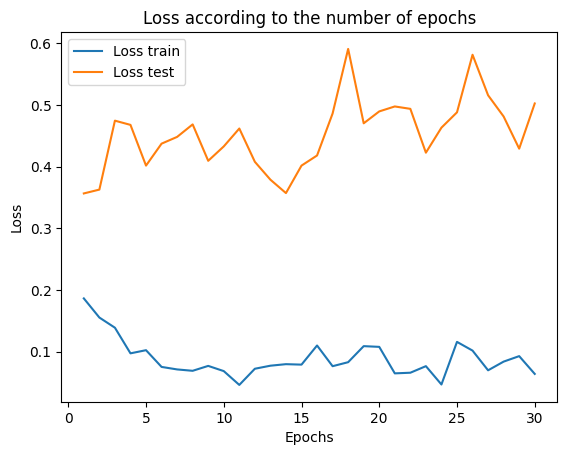

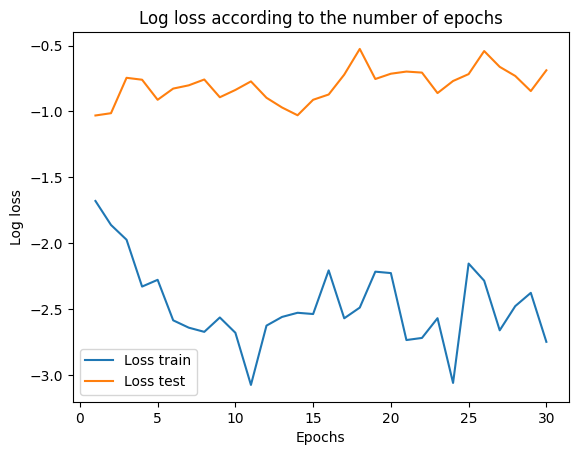

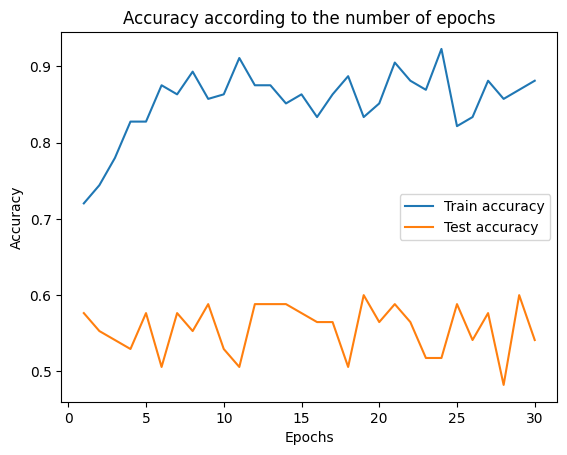

Confusion Matrix, Without Normalization


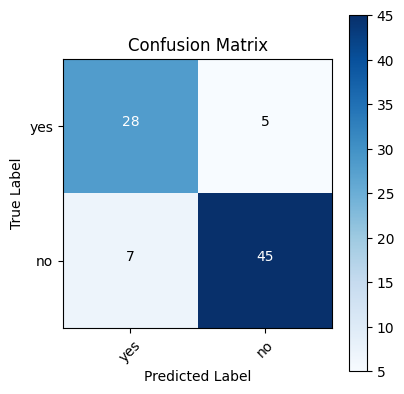

              precision    recall  f1-score   support

         yes       0.80      0.85      0.82        33
          no       0.90      0.87      0.88        52

    accuracy                           0.86        85
   macro avg       0.85      0.86      0.85        85
weighted avg       0.86      0.86      0.86        85



In [20]:
evaluation_plots(model_eff_net7, test_loader, loss_train, acc_train, loss_test, acc_test)

### EfficientNet b6

Less parameters than the b7

In [25]:
model_eff_net6 = models.efficientnet_b6(weights='DEFAULT')

In [26]:
model_eff_net6 = model_eff_net6.to(device)

In [27]:
print(model_eff_net6)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [28]:
for param in model_eff_net6.parameters():
    param.requires_grad = False

model_eff_net6.classifier._modules['1'] = nn.Linear(2304, 2)
model_eff_net6.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [29]:
print(model_eff_net6)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [30]:
model_eff_net6 = model_eff_net6.to(device)

In [31]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net6.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net6, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Train - Loss: 0.1927 Acc: 0.7024


  3%|▎         | 1/30 [00:30<14:35, 30.21s/it]

Test - Loss: 0.3380 Acc: 0.4941
Train - Loss: 0.1744 Acc: 0.7143


  7%|▋         | 2/30 [00:58<13:26, 28.82s/it]

Test - Loss: 0.3840 Acc: 0.5059
Train - Loss: 0.0886 Acc: 0.8274


 10%|█         | 3/30 [01:25<12:44, 28.32s/it]

Test - Loss: 0.3513 Acc: 0.5647
Train - Loss: 0.1259 Acc: 0.8095


 13%|█▎        | 4/30 [01:53<12:10, 28.10s/it]

Test - Loss: 0.4087 Acc: 0.4941
Train - Loss: 0.0791 Acc: 0.8452


 17%|█▋        | 5/30 [02:21<11:39, 27.97s/it]

Test - Loss: 0.3973 Acc: 0.5412
Train - Loss: 0.0853 Acc: 0.8155


 20%|██        | 6/30 [02:49<11:10, 27.94s/it]

Test - Loss: 0.3549 Acc: 0.4824
Train - Loss: 0.0562 Acc: 0.8810


 23%|██▎       | 7/30 [03:17<10:42, 27.94s/it]

Test - Loss: 0.3530 Acc: 0.5059
Train - Loss: 0.0933 Acc: 0.7798


 27%|██▋       | 8/30 [03:44<10:13, 27.90s/it]

Test - Loss: 0.4783 Acc: 0.4824
Train - Loss: 0.0949 Acc: 0.8690


 30%|███       | 9/30 [04:12<09:46, 27.91s/it]

Test - Loss: 0.3966 Acc: 0.5294
Train - Loss: 0.0584 Acc: 0.8810


 33%|███▎      | 10/30 [04:41<09:23, 28.17s/it]

Test - Loss: 0.4463 Acc: 0.5059
Train - Loss: 0.0977 Acc: 0.8274


 37%|███▋      | 11/30 [05:09<08:54, 28.13s/it]

Test - Loss: 0.4221 Acc: 0.4824
Train - Loss: 0.0636 Acc: 0.8690


 40%|████      | 12/30 [05:37<08:24, 28.04s/it]

Test - Loss: 0.3076 Acc: 0.6706
Train - Loss: 0.1033 Acc: 0.8393


 43%|████▎     | 13/30 [06:05<07:55, 27.97s/it]

Test - Loss: 0.3436 Acc: 0.5294
Train - Loss: 0.0677 Acc: 0.8750


 47%|████▋     | 14/30 [06:33<07:26, 27.93s/it]

Test - Loss: 0.3989 Acc: 0.4941
Train - Loss: 0.0997 Acc: 0.8214


 50%|█████     | 15/30 [07:01<06:59, 27.97s/it]

Test - Loss: 0.4515 Acc: 0.4706
Train - Loss: 0.0547 Acc: 0.8869


 53%|█████▎    | 16/30 [07:29<06:32, 28.00s/it]

Test - Loss: 0.3739 Acc: 0.5294
Train - Loss: 0.0988 Acc: 0.8274


 57%|█████▋    | 17/30 [07:58<06:07, 28.27s/it]

Test - Loss: 0.4012 Acc: 0.5647
Train - Loss: 0.0748 Acc: 0.8869


 60%|██████    | 18/30 [08:25<05:37, 28.08s/it]

Test - Loss: 0.4424 Acc: 0.5765
Train - Loss: 0.1135 Acc: 0.7917


 63%|██████▎   | 19/30 [08:54<05:11, 28.32s/it]

Test - Loss: 0.3872 Acc: 0.5176
Train - Loss: 0.0608 Acc: 0.8750


 67%|██████▋   | 20/30 [09:23<04:45, 28.52s/it]

Test - Loss: 0.5045 Acc: 0.5176
Train - Loss: 0.0938 Acc: 0.8571


 70%|███████   | 21/30 [09:52<04:18, 28.70s/it]

Test - Loss: 0.4158 Acc: 0.4941
Train - Loss: 0.0399 Acc: 0.9226


 73%|███████▎  | 22/30 [10:22<03:50, 28.86s/it]

Test - Loss: 0.4343 Acc: 0.4824
Train - Loss: 0.0923 Acc: 0.8631


 77%|███████▋  | 23/30 [10:51<03:22, 28.95s/it]

Test - Loss: 0.4813 Acc: 0.5529
Train - Loss: 0.0560 Acc: 0.8869


 80%|████████  | 24/30 [11:19<02:53, 28.91s/it]

Test - Loss: 0.4491 Acc: 0.5647
Train - Loss: 0.0759 Acc: 0.8690


 83%|████████▎ | 25/30 [11:49<02:24, 28.95s/it]

Test - Loss: 0.4383 Acc: 0.5294
Train - Loss: 0.0913 Acc: 0.8036


 87%|████████▋ | 26/30 [12:17<01:54, 28.74s/it]

Test - Loss: 0.5098 Acc: 0.5529
Train - Loss: 0.1153 Acc: 0.8095


 90%|█████████ | 27/30 [12:45<01:25, 28.53s/it]

Test - Loss: 0.5183 Acc: 0.4941
Train - Loss: 0.0845 Acc: 0.8571


 93%|█████████▎| 28/30 [13:13<00:56, 28.40s/it]

Test - Loss: 0.4480 Acc: 0.5529
Train - Loss: 0.0580 Acc: 0.8750


 97%|█████████▋| 29/30 [13:42<00:28, 28.62s/it]

Test - Loss: 0.4611 Acc: 0.5882
Train - Loss: 0.0668 Acc: 0.9048


100%|██████████| 30/30 [14:10<00:00, 28.35s/it]

Test - Loss: 0.4924 Acc: 0.4588


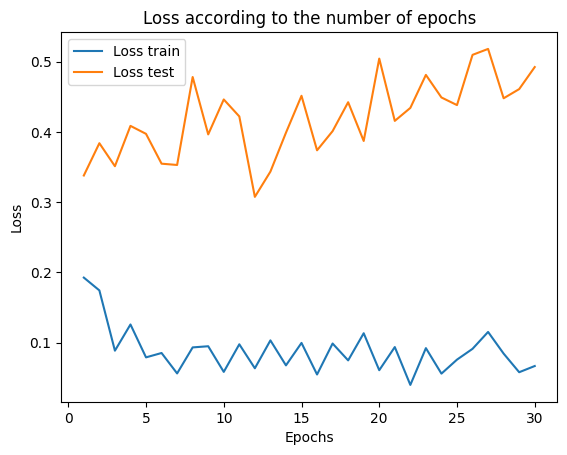

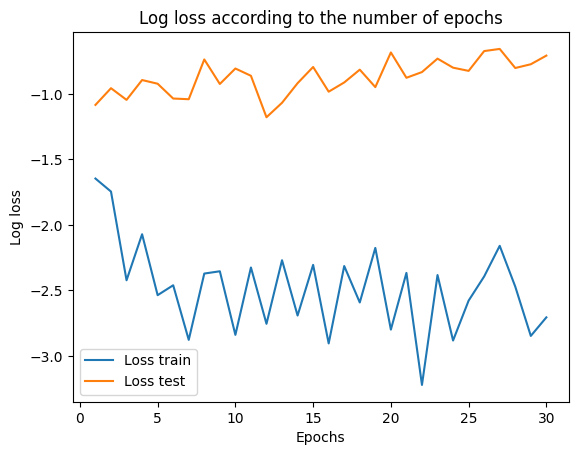

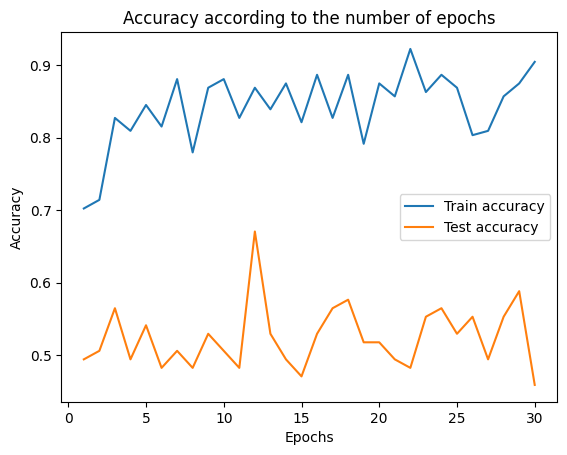

Confusion Matrix, Without Normalization


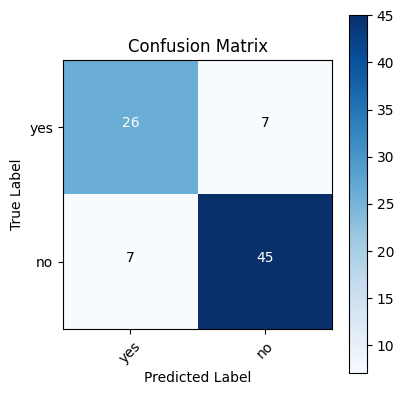

              precision    recall  f1-score   support

         yes       0.79      0.79      0.79        33
          no       0.87      0.87      0.87        52

    accuracy                           0.84        85
   macro avg       0.83      0.83      0.83        85
weighted avg       0.84      0.84      0.84        85



In [32]:
evaluation_plots(model_eff_net6, test_loader, loss_train, acc_train, loss_test, acc_test)

### EfficientNet b1

In [37]:
model_eff_net1 = models.efficientnet_b1(weights='DEFAULT')

In [38]:
model_eff_net1 = model_eff_net1.to(device)

In [39]:
print(model_eff_net1)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [40]:
for param in model_eff_net1.parameters():
    param.requires_grad = False

model_eff_net1.classifier._modules['1'] = nn.Linear(1280, 2)
model_eff_net1.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [41]:
print(model_eff_net1)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
model_eff_net1 = model_eff_net1.to(device)

In [43]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net1.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net1, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.0918 Acc: 0.7202


 10%|█         | 1/10 [00:28<04:19, 28.83s/it]

Test - Loss: 0.1766 Acc: 0.5647
Train - Loss: 0.0503 Acc: 0.8095


 20%|██        | 2/10 [00:55<03:40, 27.52s/it]

Test - Loss: 0.1733 Acc: 0.5882
Train - Loss: 0.0550 Acc: 0.8274


 30%|███       | 3/10 [01:22<03:09, 27.10s/it]

Test - Loss: 0.1653 Acc: 0.6118
Train - Loss: 0.0348 Acc: 0.9167


 40%|████      | 4/10 [01:48<02:41, 26.90s/it]

Test - Loss: 0.1734 Acc: 0.6000
Train - Loss: 0.0273 Acc: 0.9107


 50%|█████     | 5/10 [02:15<02:15, 27.07s/it]

Test - Loss: 0.1942 Acc: 0.5882
Train - Loss: 0.0173 Acc: 0.9405


 60%|██████    | 6/10 [02:42<01:47, 26.91s/it]

Test - Loss: 0.1699 Acc: 0.6118
Train - Loss: 0.0213 Acc: 0.9345


 70%|███████   | 7/10 [03:09<01:20, 26.79s/it]

Test - Loss: 0.1895 Acc: 0.5647
Train - Loss: 0.0287 Acc: 0.9048


 80%|████████  | 8/10 [03:36<00:53, 26.82s/it]

Test - Loss: 0.1989 Acc: 0.5765
Train - Loss: 0.0263 Acc: 0.9107


 90%|█████████ | 9/10 [04:03<00:26, 26.95s/it]

Test - Loss: 0.1891 Acc: 0.6471
Train - Loss: 0.0192 Acc: 0.9345


100%|██████████| 10/10 [04:29<00:00, 26.98s/it]

Test - Loss: 0.2015 Acc: 0.6353


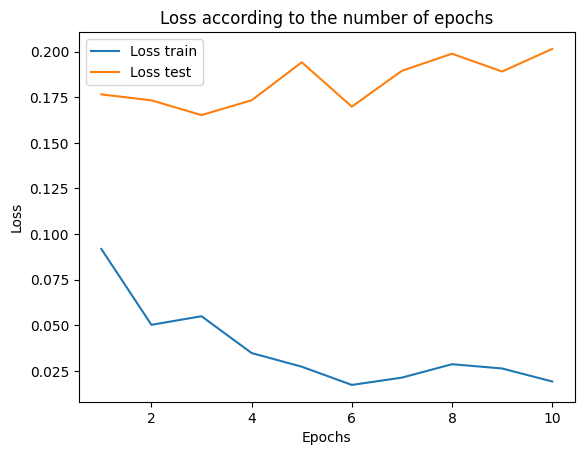

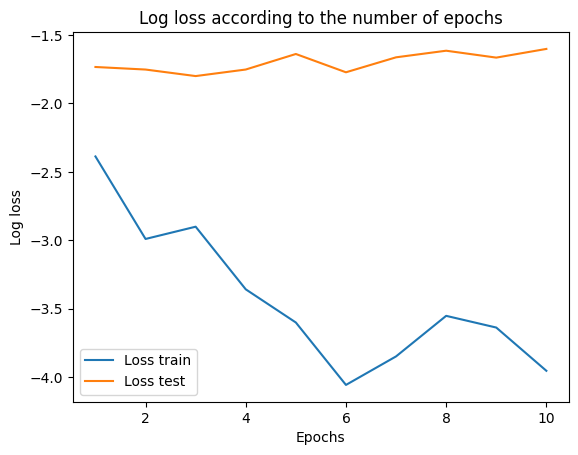

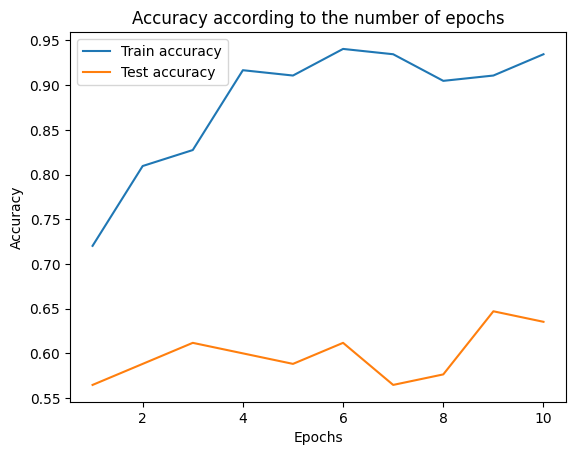

Confusion Matrix, Without Normalization


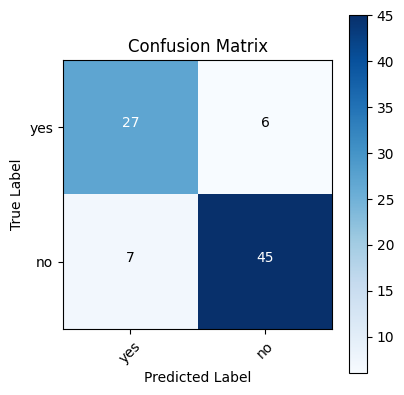

              precision    recall  f1-score   support

         yes       0.79      0.82      0.81        33
          no       0.88      0.87      0.87        52

    accuracy                           0.85        85
   macro avg       0.84      0.84      0.84        85
weighted avg       0.85      0.85      0.85        85



In [44]:
evaluation_plots(model_eff_net1, test_loader, loss_train, acc_train, loss_test, acc_test)

### EfficientNet b0
The simplest of the efficient nets

In [49]:
model_eff_net0 = models.efficientnet_b0(weights='DEFAULT')

In [50]:
model_eff_net0 = model_eff_net0.to(device)

In [51]:
print(model_eff_net0)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [52]:
for param in model_eff_net0.parameters():
    param.requires_grad = False

model_eff_net0.classifier._modules['1'] = nn.Linear(1280, 2)
model_eff_net0.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [53]:
print(model_eff_net0)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [54]:
model_eff_net0 = model_eff_net0.to(device)

In [55]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net0.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net0, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2555 Acc: 0.6845


 10%|█         | 1/10 [00:26<03:59, 26.65s/it]

Test - Loss: 0.2839 Acc: 0.4824
Train - Loss: 0.0503 Acc: 0.8750


 20%|██        | 2/10 [00:52<03:30, 26.36s/it]

Test - Loss: 0.2440 Acc: 0.6000
Train - Loss: 0.1040 Acc: 0.8214


 30%|███       | 3/10 [01:18<03:03, 26.19s/it]

Test - Loss: 0.3596 Acc: 0.4941
Train - Loss: 0.0743 Acc: 0.8512


 40%|████      | 4/10 [01:44<02:36, 26.06s/it]

Test - Loss: 0.3582 Acc: 0.5529
Train - Loss: 0.0805 Acc: 0.8393


 50%|█████     | 5/10 [02:10<02:10, 26.05s/it]

Test - Loss: 0.3110 Acc: 0.5882
Train - Loss: 0.0445 Acc: 0.9048


 60%|██████    | 6/10 [02:36<01:44, 26.03s/it]

Test - Loss: 0.3020 Acc: 0.5765
Train - Loss: 0.0553 Acc: 0.8571


 70%|███████   | 7/10 [03:02<01:18, 26.06s/it]

Test - Loss: 0.2734 Acc: 0.5412
Train - Loss: 0.0637 Acc: 0.8512


 80%|████████  | 8/10 [03:28<00:52, 26.04s/it]

Test - Loss: 0.3218 Acc: 0.6471
Train - Loss: 0.0805 Acc: 0.8571


 90%|█████████ | 9/10 [03:54<00:26, 26.07s/it]

Test - Loss: 0.3590 Acc: 0.6235
Train - Loss: 0.0859 Acc: 0.8631


100%|██████████| 10/10 [04:21<00:00, 26.10s/it]

Test - Loss: 0.4233 Acc: 0.5647


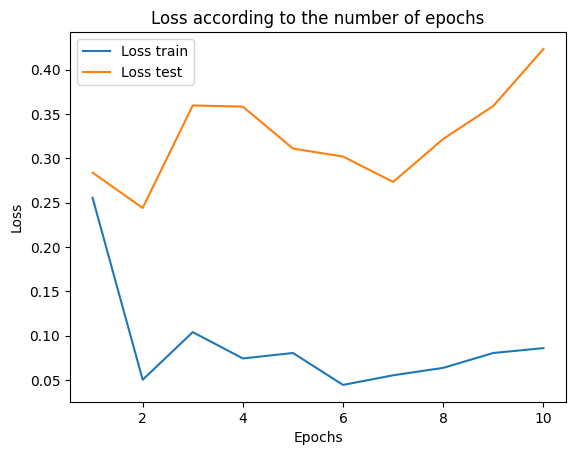

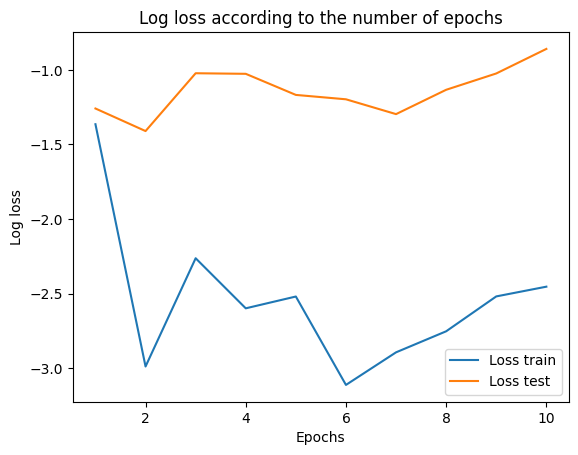

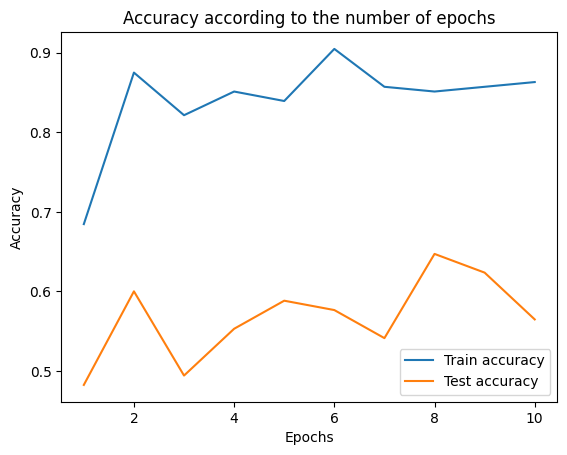

Confusion Matrix, Without Normalization


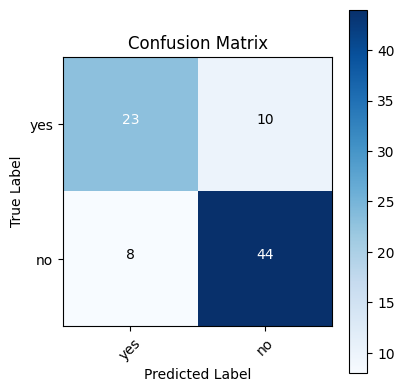

              precision    recall  f1-score   support

         yes       0.74      0.70      0.72        33
          no       0.81      0.85      0.83        52

    accuracy                           0.79        85
   macro avg       0.78      0.77      0.77        85
weighted avg       0.79      0.79      0.79        85



In [56]:
evaluation_plots(model_eff_net0, test_loader, loss_train, acc_train, loss_test, acc_test)

### EfficientNet b2

In [61]:
model_eff_net2 = models.efficientnet_b2(weights='DEFAULT')

In [62]:
model_eff_net2 = model_eff_net2.to(device)

In [63]:
print(model_eff_net2)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [64]:
for param in model_eff_net2.parameters():
    param.requires_grad = False

model_eff_net2.classifier._modules['1'] = nn.Linear(1408, 2)
model_eff_net2.classifier._modules['2'] = torch.nn.LogSoftmax(dim = 1)

In [65]:
print(model_eff_net2)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [66]:
model_eff_net2 = model_eff_net2.to(device)

In [67]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_eff_net2.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_eff_net2, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2634 Acc: 0.6369


 10%|█         | 1/10 [00:28<04:14, 28.25s/it]

Test - Loss: 0.3550 Acc: 0.6000
Train - Loss: 0.1423 Acc: 0.7917


 20%|██        | 2/10 [00:54<03:37, 27.24s/it]

Test - Loss: 0.3830 Acc: 0.5059
Train - Loss: 0.1022 Acc: 0.8095


 30%|███       | 3/10 [01:21<03:08, 26.93s/it]

Test - Loss: 0.3359 Acc: 0.5647
Train - Loss: 0.1097 Acc: 0.7917


 40%|████      | 4/10 [01:47<02:40, 26.75s/it]

Test - Loss: 0.3676 Acc: 0.5882
Train - Loss: 0.1081 Acc: 0.8095


 50%|█████     | 5/10 [02:14<02:13, 26.64s/it]

Test - Loss: 0.4053 Acc: 0.5765
Train - Loss: 0.1079 Acc: 0.8452


 60%|██████    | 6/10 [02:40<01:46, 26.60s/it]

Test - Loss: 0.3243 Acc: 0.5765
Train - Loss: 0.1376 Acc: 0.7381


 70%|███████   | 7/10 [03:07<01:19, 26.56s/it]

Test - Loss: 0.4005 Acc: 0.5882
Train - Loss: 0.1253 Acc: 0.8155


 80%|████████  | 8/10 [03:33<00:53, 26.52s/it]

Test - Loss: 0.3755 Acc: 0.5765
Train - Loss: 0.1220 Acc: 0.7798


 90%|█████████ | 9/10 [04:00<00:26, 26.53s/it]

Test - Loss: 0.3242 Acc: 0.5294
Train - Loss: 0.0685 Acc: 0.8750


100%|██████████| 10/10 [04:26<00:00, 26.68s/it]

Test - Loss: 0.3325 Acc: 0.5176


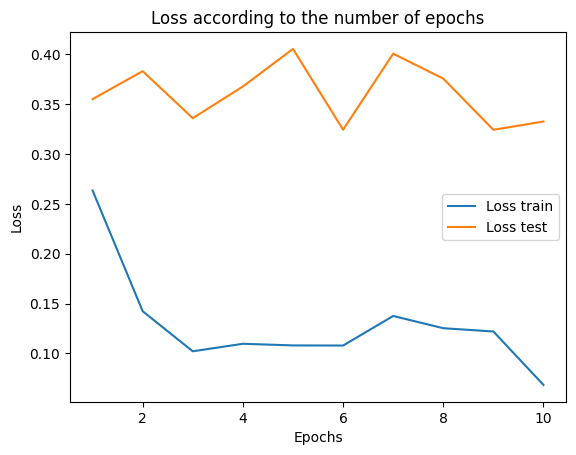

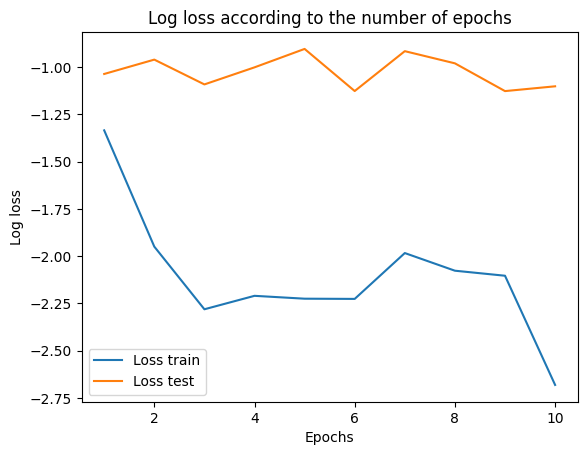

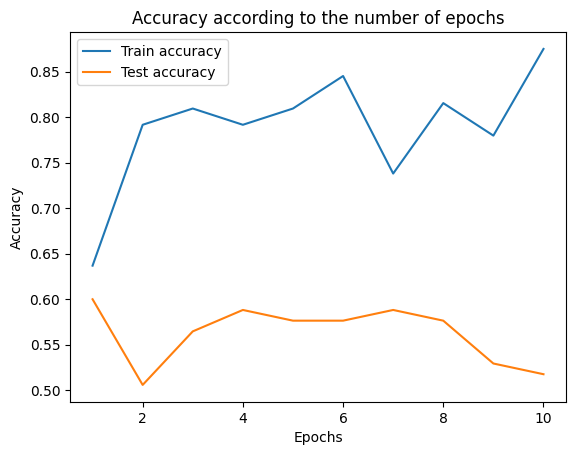

Confusion Matrix, Without Normalization


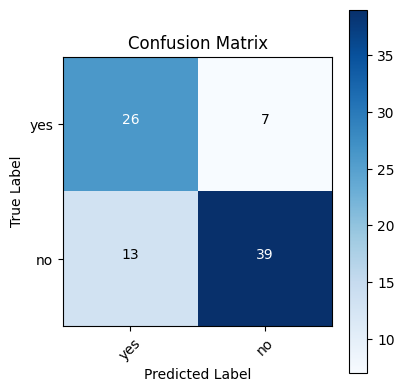

              precision    recall  f1-score   support

         yes       0.67      0.79      0.72        33
          no       0.85      0.75      0.80        52

    accuracy                           0.76        85
   macro avg       0.76      0.77      0.76        85
weighted avg       0.78      0.76      0.77        85



In [68]:
evaluation_plots(model_eff_net2, test_loader, loss_train, acc_train, loss_test, acc_test)

### Summary

In [73]:
results = {'Accuracy':[accuracy_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                       accuracy_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                       accuracy_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                       accuracy_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                       accuracy_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])],
           'Precision':[precision_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                       precision_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                       precision_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                       precision_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                       precision_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])],
           'Recall':[recall_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                     recall_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                     recall_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                     recall_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                     recall_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])],
           'F1-score':[f1_score(predict(model_eff_net0, test_loader)[0],predict(model_eff_net0, test_loader)[1]),
                     f1_score(predict(model_eff_net1, test_loader)[0],predict(model_eff_net1, test_loader)[1]),
                     f1_score(predict(model_eff_net2, test_loader)[0],predict(model_eff_net2, test_loader)[1]),
                     f1_score(predict(model_eff_net6, test_loader)[0],predict(model_eff_net6, test_loader)[1]),
                     f1_score(predict(model_eff_net7, test_loader)[0],predict(model_eff_net7, test_loader)[1])]}

eff_net_results = pd.DataFrame(results, index=['EfficientNet b0', 'EfficientNet b1', 'EfficientNet b2', 'EfficientNet b6', 'EfficientNet b7'])
eff_net_results

,Accuracy,Precision,Recall,F1-score
EfficientNet b0,0.788235,0.814815,0.846154,0.830189
EfficientNet b1,0.847059,0.882353,0.865385,0.873786
EfficientNet b2,0.764706,0.847826,0.750000,0.795918
EfficientNet b6,0.835294,0.865385,0.865385,0.865385
EfficientNet b7,0.858824,0.900000,0.865385,0.882353


## Resnet

### Resnet 50

In [74]:
model_res50 = models.resnet50(weights='DEFAULT')

In [75]:
model_res50 = model_res50.to(device)

In [76]:
print(model_res50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [77]:
print(model_res50.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [78]:
for param in model_res50.parameters():
    param.requires_grad = False

model_res50.fc = nn.Linear(2048, 2)

model_res50_lsm = nn.Sequential(model_res50, torch.nn.LogSoftmax(dim = 1))

In [79]:
print(model_res50_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [80]:
model_res50_lsm = model_res50_lsm.to(device)

In [76]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-4
optimizer_cl = torch.optim.RMSprop(model_res50_lsm.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_res50_lsm, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.2259 Acc: 0.6369


 10%|█         | 1/10 [00:28<04:19, 28.89s/it]

Test - Loss: 0.2564 Acc: 0.5059
Train - Loss: 0.0569 Acc: 0.8810


 20%|██        | 2/10 [00:56<03:43, 27.88s/it]

Test - Loss: 0.1780 Acc: 0.6353
Train - Loss: 0.0581 Acc: 0.8512


 30%|███       | 3/10 [01:23<03:13, 27.65s/it]

Test - Loss: 0.1711 Acc: 0.5647
Train - Loss: 0.0641 Acc: 0.8214


 40%|████      | 4/10 [01:50<02:45, 27.54s/it]

Test - Loss: 0.1972 Acc: 0.5647
Train - Loss: 0.0476 Acc: 0.8869


 50%|█████     | 5/10 [02:18<02:17, 27.52s/it]

Test - Loss: 0.1947 Acc: 0.6000
Train - Loss: 0.0423 Acc: 0.8810


 60%|██████    | 6/10 [02:44<01:48, 27.23s/it]

Test - Loss: 0.1826 Acc: 0.6353
Train - Loss: 0.0150 Acc: 0.9524


 70%|███████   | 7/10 [03:12<01:22, 27.37s/it]

Test - Loss: 0.1812 Acc: 0.6235
Train - Loss: 0.0201 Acc: 0.9405


 80%|████████  | 8/10 [03:39<00:54, 27.32s/it]

Test - Loss: 0.1778 Acc: 0.6000
Train - Loss: 0.0191 Acc: 0.9405


 90%|█████████ | 9/10 [04:07<00:27, 27.41s/it]

Test - Loss: 0.1814 Acc: 0.6000
Train - Loss: 0.0065 Acc: 0.9821


100%|██████████| 10/10 [04:35<00:00, 27.54s/it]

Test - Loss: 0.1967 Acc: 0.6118


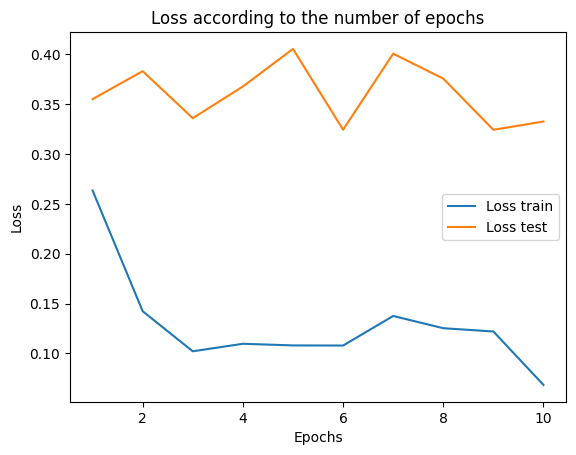

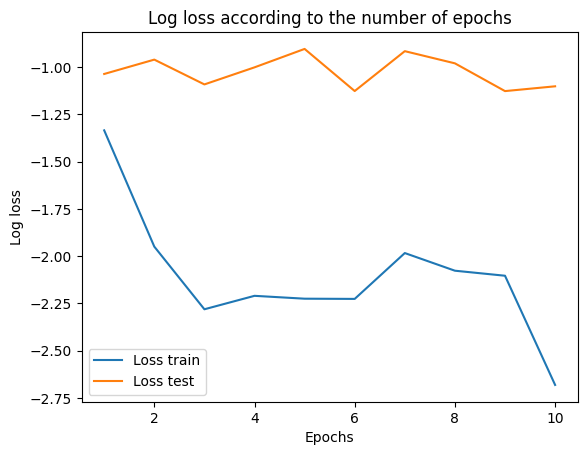

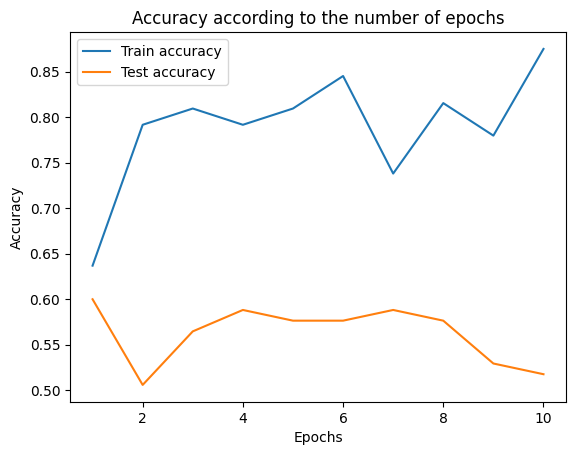

Confusion Matrix, Without Normalization


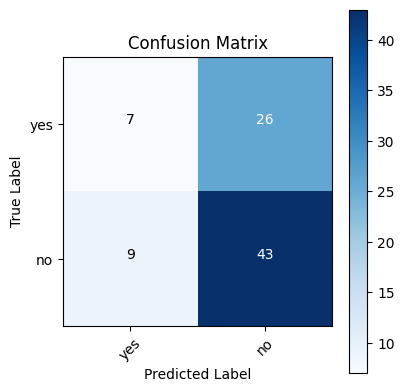

              precision    recall  f1-score   support

         yes       0.44      0.21      0.29        33
          no       0.62      0.83      0.71        52

    accuracy                           0.59        85
   macro avg       0.53      0.52      0.50        85
weighted avg       0.55      0.59      0.55        85



In [81]:
evaluation_plots(model_res50_lsm, test_loader, loss_train, acc_train, loss_test, acc_test)

### Resnet 34

In [82]:
model_res34 = models.resnet34(weights='DEFAULT')

In [83]:
model_res34 = model_res34.to(device)

In [84]:
print(model_res34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
print(model_res34.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [86]:
for param in model_res34.parameters():
    param.requires_grad = False

model_res34.fc = nn.Linear(512, 2)

model_res34_lsm = nn.Sequential(model_res34, torch.nn.LogSoftmax(dim = 1))

In [87]:
print(model_res34_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [88]:
model_res34_lsm = model_res34_lsm.to(device)

In [89]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_res34_lsm.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_res34_lsm, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.8007 Acc: 0.6310


 10%|█         | 1/10 [00:26<03:58, 26.47s/it]

Test - Loss: 0.6531 Acc: 0.6118
Train - Loss: 0.2001 Acc: 0.7321


 20%|██        | 2/10 [00:52<03:29, 26.14s/it]

Test - Loss: 0.4372 Acc: 0.5529
Train - Loss: 0.1104 Acc: 0.8274


 30%|███       | 3/10 [01:18<03:01, 25.92s/it]

Test - Loss: 0.4718 Acc: 0.4471
Train - Loss: 0.1193 Acc: 0.8452


 40%|████      | 4/10 [01:43<02:34, 25.83s/it]

Test - Loss: 0.4094 Acc: 0.6353
Train - Loss: 0.1058 Acc: 0.8452


 50%|█████     | 5/10 [02:09<02:08, 25.72s/it]

Test - Loss: 0.4450 Acc: 0.6824
Train - Loss: 0.1535 Acc: 0.8214


 60%|██████    | 6/10 [02:34<01:42, 25.65s/it]

Test - Loss: 0.4060 Acc: 0.6353
Train - Loss: 0.0333 Acc: 0.9226


 70%|███████   | 7/10 [03:00<01:16, 25.61s/it]

Test - Loss: 0.7107 Acc: 0.6235
Train - Loss: 0.0852 Acc: 0.8810


 80%|████████  | 8/10 [03:25<00:51, 25.58s/it]

Test - Loss: 0.4605 Acc: 0.6471
Train - Loss: 0.0487 Acc: 0.8988


 90%|█████████ | 9/10 [03:51<00:25, 25.56s/it]

Test - Loss: 0.5246 Acc: 0.6471
Train - Loss: 0.1371 Acc: 0.8690


100%|██████████| 10/10 [04:16<00:00, 25.70s/it]

Test - Loss: 0.4177 Acc: 0.5294


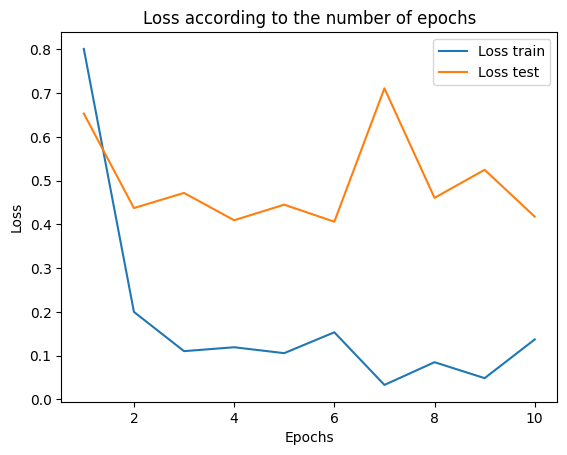

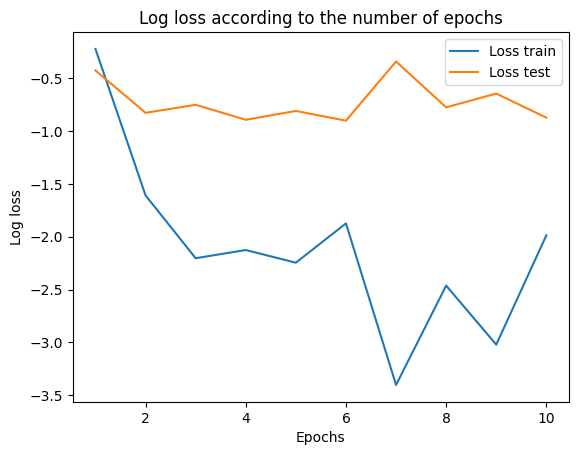

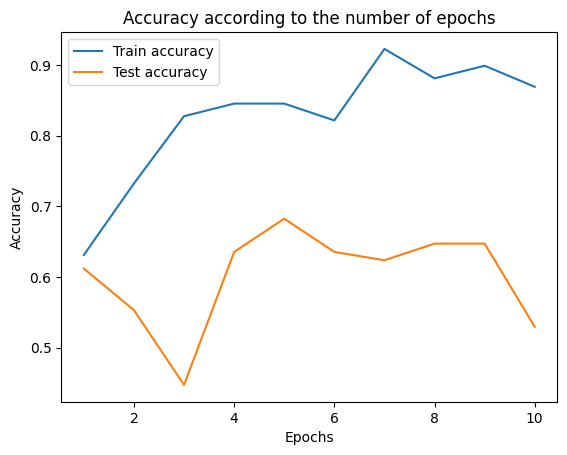

Confusion Matrix, Without Normalization


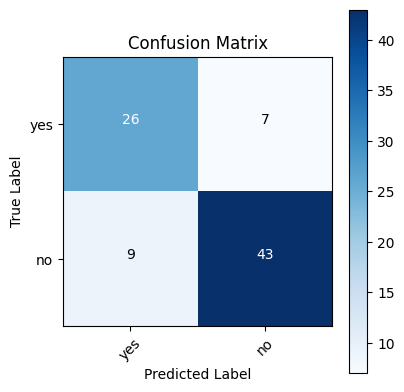

              precision    recall  f1-score   support

         yes       0.74      0.79      0.76        33
          no       0.86      0.83      0.84        52

    accuracy                           0.81        85
   macro avg       0.80      0.81      0.80        85
weighted avg       0.81      0.81      0.81        85



In [91]:
evaluation_plots(model_res34_lsm, test_loader, loss_train, acc_train, loss_test, acc_test)

### Resnet 152

In [95]:
model_res152 = models.resnet152(weights='DEFAULT')

In [96]:
model_res152 = model_res152.to(device)

In [97]:
print(model_res152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [98]:
print(model_res152.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [99]:
for param in model_res152.parameters():
    param.requires_grad = False

model_res152.fc = nn.Linear(2048, 2)

model_res152_lsm = nn.Sequential(model_res152, torch.nn.LogSoftmax(dim = 1))

In [100]:
print(model_res152_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [101]:
model_res152_lsm = model_res152_lsm.to(device)

In [102]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_res152_lsm.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_res152_lsm, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 0.4213 Acc: 0.6548


 10%|█         | 1/10 [00:28<04:12, 28.00s/it]

Test - Loss: 0.2979 Acc: 0.6118
Train - Loss: 0.0552 Acc: 0.8750


 20%|██        | 2/10 [00:55<03:42, 27.83s/it]

Test - Loss: 0.2414 Acc: 0.5765
Train - Loss: 0.0935 Acc: 0.8274


 30%|███       | 3/10 [01:23<03:13, 27.62s/it]

Test - Loss: 0.2179 Acc: 0.5765
Train - Loss: 0.0311 Acc: 0.9226


 40%|████      | 4/10 [01:51<02:46, 27.81s/it]

Test - Loss: 0.2132 Acc: 0.5294
Train - Loss: 0.0201 Acc: 0.9405


 50%|█████     | 5/10 [02:20<02:21, 28.22s/it]

Test - Loss: 0.2191 Acc: 0.5412
Train - Loss: 0.0166 Acc: 0.9583


 60%|██████    | 6/10 [02:47<01:51, 27.98s/it]

Test - Loss: 0.2160 Acc: 0.5882
Train - Loss: 0.0071 Acc: 0.9762


 70%|███████   | 7/10 [03:15<01:24, 28.01s/it]

Test - Loss: 0.2098 Acc: 0.5882
Train - Loss: 0.0212 Acc: 0.9405


 80%|████████  | 8/10 [03:43<00:55, 27.84s/it]

Test - Loss: 0.2571 Acc: 0.6000
Train - Loss: 0.0269 Acc: 0.9286


 90%|█████████ | 9/10 [04:10<00:27, 27.72s/it]

Test - Loss: 0.2162 Acc: 0.6235
Train - Loss: 0.0150 Acc: 0.9464


100%|██████████| 10/10 [04:38<00:00, 27.84s/it]

Test - Loss: 0.2071 Acc: 0.5882


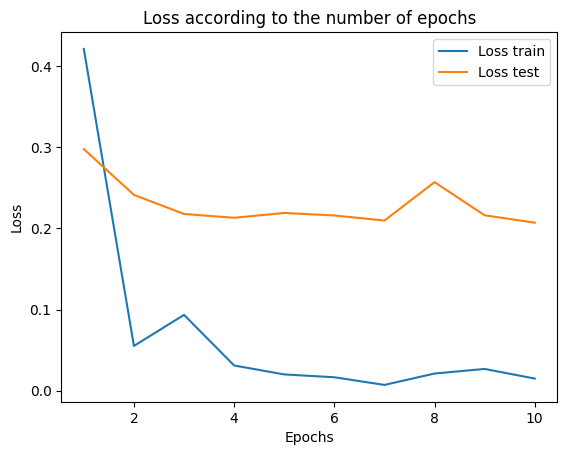

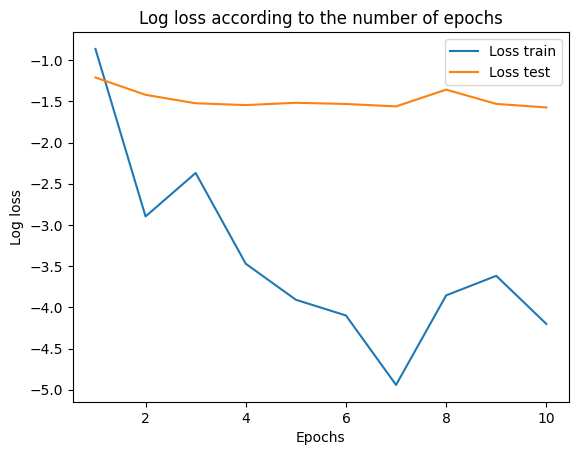

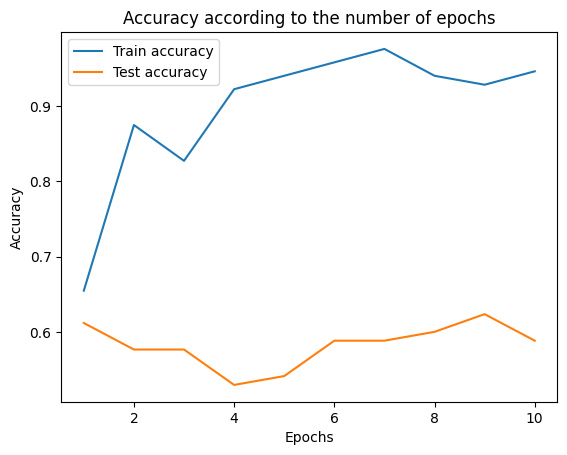

Confusion Matrix, Without Normalization


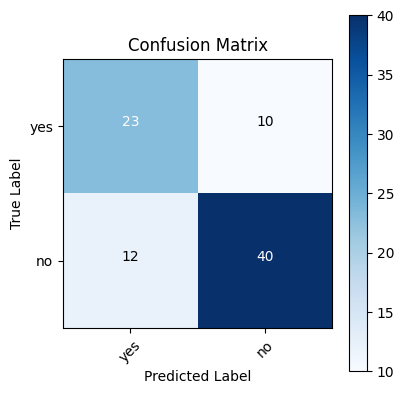

              precision    recall  f1-score   support

         yes       0.66      0.70      0.68        33
          no       0.80      0.77      0.78        52

    accuracy                           0.74        85
   macro avg       0.73      0.73      0.73        85
weighted avg       0.74      0.74      0.74        85



In [103]:
evaluation_plots(model_res152_lsm, test_loader, loss_train, acc_train, loss_test, acc_test)

### Results

In [108]:
results = {'Accuracy':[accuracy_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                       accuracy_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                       accuracy_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])],
           'Precision':[precision_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                       precision_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                       precision_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])],
           'Recall':[recall_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                     recall_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                     recall_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])],
           'F1-score':[f1_score(predict(model_res34_lsm, test_loader)[0],predict(model_res34_lsm, test_loader)[1]),
                     f1_score(predict(model_res50_lsm, test_loader)[0],predict(model_res50_lsm, test_loader)[1]),
                     f1_score(predict(model_res152_lsm, test_loader)[0],predict(model_res152_lsm, test_loader)[1])]}

resnet_result = pd.DataFrame(results, index=['Resnet34', 'Resnet50', 'Resnet152'])

results = pd.concat([eff_net_results, resnet_result], axis=0)

In [109]:
results

,Accuracy,Precision,Recall,F1-score
EfficientNet b0,0.788235,0.814815,0.846154,0.830189
EfficientNet b1,0.847059,0.882353,0.865385,0.873786
EfficientNet b2,0.764706,0.847826,0.750000,0.795918
EfficientNet b6,0.835294,0.865385,0.865385,0.865385
EfficientNet b7,0.858824,0.900000,0.865385,0.882353
Resnet34,0.811765,0.860000,0.826923,0.843137
Resnet50,0.588235,0.623188,0.826923,0.710744
Resnet152,0.741176,0.800000,0.769231,0.784314


## VGG 

### VGG11

In [110]:
model_vgg11 = models.vgg11()

In [111]:
print(model_vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [112]:
model_vgg11 = model_vgg11.to(device)

In [113]:
for param in model_vgg11.parameters():
    param.requires_grad = False

model_vgg11.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

model_vgg11.classifier._modules['0'] = nn.Linear(512*2*2, 4096)
model_vgg11.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg11.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [114]:
print(model_vgg11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [115]:
model_vgg11 = model_vgg11.to(device)

In [116]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_vgg11.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_vgg11, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 13.9829 Acc: 0.4881


 10%|█         | 1/10 [00:27<04:06, 27.37s/it]

Test - Loss: 8.3218 Acc: 0.5882
Train - Loss: 7.4812 Acc: 0.5536


 20%|██        | 2/10 [00:53<03:32, 26.52s/it]

Test - Loss: 3.7549 Acc: 0.5647
Train - Loss: 4.0856 Acc: 0.5536


 30%|███       | 3/10 [01:19<03:05, 26.52s/it]

Test - Loss: 4.1261 Acc: 0.5059
Train - Loss: 4.3412 Acc: 0.5893


 40%|████      | 4/10 [01:45<02:38, 26.37s/it]

Test - Loss: 3.1479 Acc: 0.5882
Train - Loss: 4.1275 Acc: 0.5595


 50%|█████     | 5/10 [02:11<02:10, 26.15s/it]

Test - Loss: 2.2760 Acc: 0.6118
Train - Loss: 4.3731 Acc: 0.5298


 60%|██████    | 6/10 [02:38<01:44, 26.23s/it]

Test - Loss: 3.9922 Acc: 0.5412
Train - Loss: 2.9756 Acc: 0.6250


 70%|███████   | 7/10 [03:04<01:18, 26.28s/it]

Test - Loss: 2.0669 Acc: 0.5176
Train - Loss: 3.5668 Acc: 0.5298


 80%|████████  | 8/10 [03:31<00:52, 26.36s/it]

Test - Loss: 2.4449 Acc: 0.6118
Train - Loss: 2.1671 Acc: 0.5833


 90%|█████████ | 9/10 [03:56<00:26, 26.22s/it]

Test - Loss: 1.8855 Acc: 0.6235
Train - Loss: 1.6469 Acc: 0.6607


100%|██████████| 10/10 [04:23<00:00, 26.37s/it]

Test - Loss: 2.4282 Acc: 0.6471


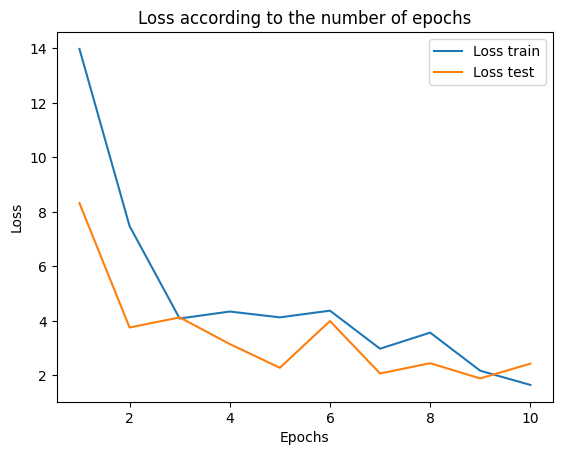

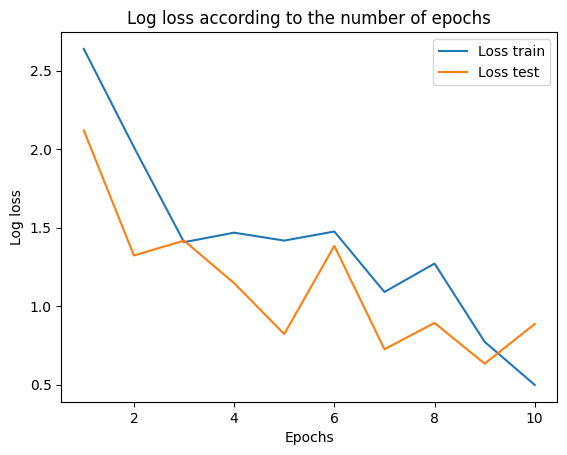

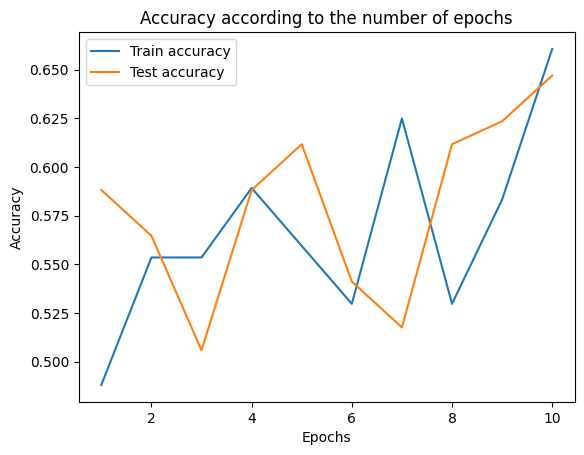

Confusion Matrix, Without Normalization


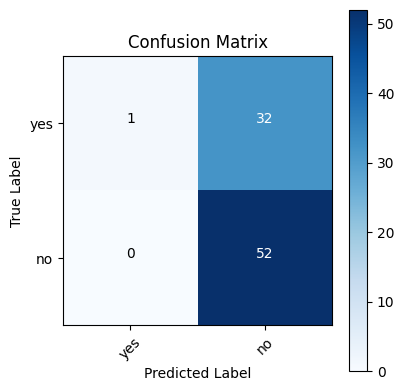

              precision    recall  f1-score   support

         yes       1.00      0.03      0.06        33
          no       0.62      1.00      0.76        52

    accuracy                           0.62        85
   macro avg       0.81      0.52      0.41        85
weighted avg       0.77      0.62      0.49        85



In [117]:
evaluation_plots(model_vgg11, test_loader, loss_train, acc_train, loss_test, acc_test)

### VGG 16

In [122]:
model_vgg16 = models.vgg16()

In [123]:
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [124]:
model_vgg16 = model_vgg16.to(device)

In [125]:
print(model_vgg16.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [126]:
for param in model_vgg16.parameters():
    param.requires_grad = False

model_vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

model_vgg16.classifier._modules['0'] = nn.Linear(512*2*2, 4096)
model_vgg16.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg16.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [127]:
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [128]:
model_vgg16 = model_vgg16.to(device)

In [129]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_vgg16.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_vgg16, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 5.9867 Acc: 0.6071


 10%|█         | 1/10 [00:27<04:07, 27.46s/it]

Test - Loss: 7.0683 Acc: 0.6118
Train - Loss: 4.5987 Acc: 0.4643


 20%|██        | 2/10 [00:54<03:39, 27.48s/it]

Test - Loss: 1.6920 Acc: 0.4588
Train - Loss: 2.1227 Acc: 0.5417


 30%|███       | 3/10 [01:22<03:12, 27.51s/it]

Test - Loss: 2.1030 Acc: 0.6000
Train - Loss: 1.3792 Acc: 0.5476


 40%|████      | 4/10 [01:49<02:42, 27.13s/it]

Test - Loss: 1.5287 Acc: 0.6000
Train - Loss: 1.4932 Acc: 0.5357


 50%|█████     | 5/10 [02:15<02:14, 26.91s/it]

Test - Loss: 2.0768 Acc: 0.4235
Train - Loss: 1.0233 Acc: 0.6012


 60%|██████    | 6/10 [02:41<01:46, 26.66s/it]

Test - Loss: 0.8672 Acc: 0.5412
Train - Loss: 0.8821 Acc: 0.5476


 70%|███████   | 7/10 [03:07<01:19, 26.51s/it]

Test - Loss: 0.9872 Acc: 0.5294
Train - Loss: 0.8522 Acc: 0.5298


 80%|████████  | 8/10 [03:35<00:53, 26.71s/it]

Test - Loss: 0.5445 Acc: 0.5412
Train - Loss: 0.6290 Acc: 0.5595


 90%|█████████ | 9/10 [04:02<00:26, 26.96s/it]

Test - Loss: 0.6496 Acc: 0.6588
Train - Loss: 0.5364 Acc: 0.5714


100%|██████████| 10/10 [04:29<00:00, 26.93s/it]

Test - Loss: 0.4925 Acc: 0.5412


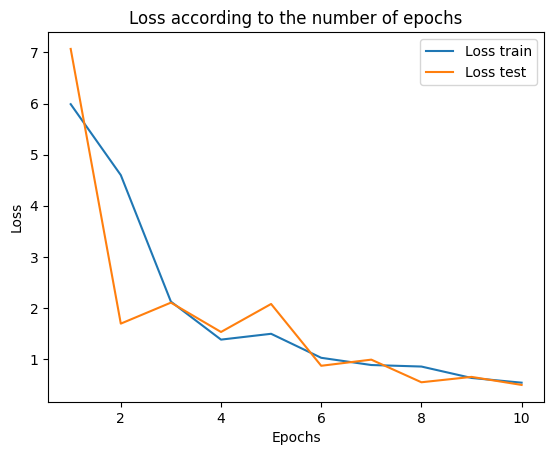

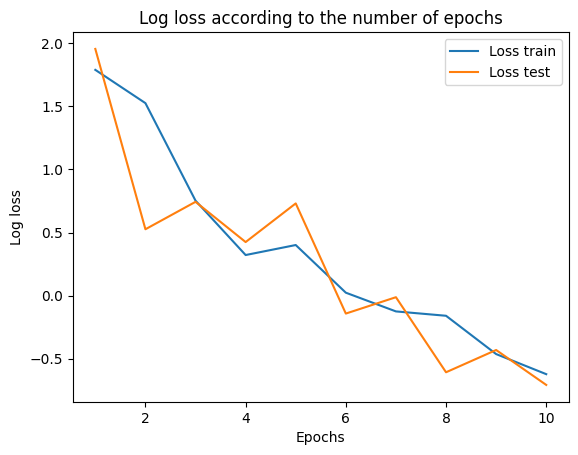

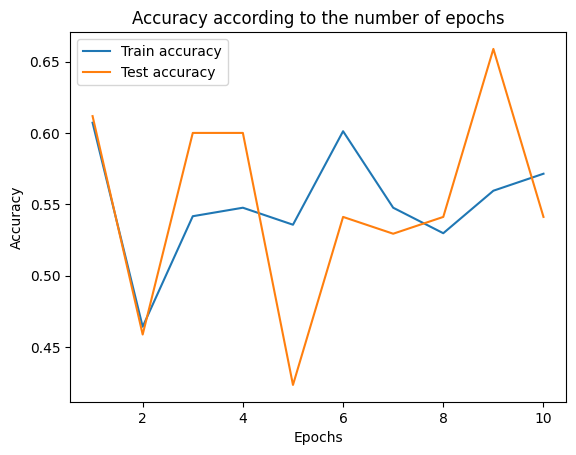

Confusion Matrix, Without Normalization


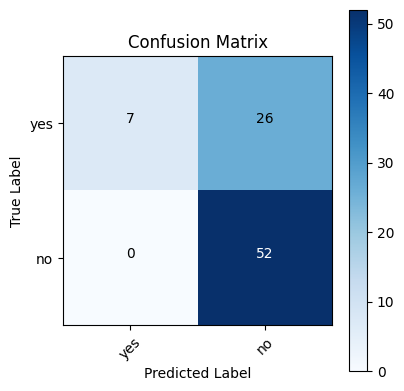

              precision    recall  f1-score   support

         yes       1.00      0.21      0.35        33
          no       0.67      1.00      0.80        52

    accuracy                           0.69        85
   macro avg       0.83      0.61      0.57        85
weighted avg       0.80      0.69      0.63        85



In [130]:
evaluation_plots(model_vgg16, test_loader, loss_train, acc_train, loss_test, acc_test)

### VGG 19

In [135]:
model_vgg19 = models.vgg19()

In [136]:
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [137]:
model_vgg19 = model_vgg19.to(device)

In [138]:
print(model_vgg19.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [139]:
for param in model_vgg19.parameters():
    param.requires_grad = False

model_vgg19.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

model_vgg19.classifier._modules['0'] = nn.Linear(512*2*2, 4096)
model_vgg19.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg19.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [140]:
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [141]:
model_vgg19 = model_vgg19.to(device)

In [142]:
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
optimizer_cl = torch.optim.RMSprop(model_vgg19.parameters())

loss_train, acc_train, loss_test, acc_test = train_and_test(model_vgg19, train_loader, test_loader, loss_fn, optimizer_cl, n_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train - Loss: 8.2504 Acc: 0.5238


 10%|█         | 1/10 [00:26<04:02, 26.99s/it]

Test - Loss: 2.9737 Acc: 0.6000
Train - Loss: 2.8681 Acc: 0.5417


 20%|██        | 2/10 [00:55<03:41, 27.72s/it]

Test - Loss: 2.5225 Acc: 0.6000
Train - Loss: 2.3179 Acc: 0.5357


 30%|███       | 3/10 [01:22<03:12, 27.55s/it]

Test - Loss: 2.1121 Acc: 0.6471
Train - Loss: 2.3293 Acc: 0.5714


 40%|████      | 4/10 [01:50<02:45, 27.65s/it]

Test - Loss: 1.4356 Acc: 0.4824
Train - Loss: 1.5390 Acc: 0.5774


 50%|█████     | 5/10 [02:17<02:18, 27.64s/it]

Test - Loss: 1.2487 Acc: 0.5529
Train - Loss: 1.2244 Acc: 0.5774


 60%|██████    | 6/10 [02:44<01:49, 27.26s/it]

Test - Loss: 1.6573 Acc: 0.5765
Train - Loss: 1.2639 Acc: 0.6012


 70%|███████   | 7/10 [03:11<01:21, 27.33s/it]

Test - Loss: 0.7989 Acc: 0.5882
Train - Loss: 1.2952 Acc: 0.5655


 80%|████████  | 8/10 [03:38<00:54, 27.16s/it]

Test - Loss: 0.9934 Acc: 0.6353
Train - Loss: 0.7711 Acc: 0.5893


 90%|█████████ | 9/10 [04:07<00:27, 27.63s/it]

Test - Loss: 2.4743 Acc: 0.6118
Train - Loss: 1.2628 Acc: 0.5714


100%|██████████| 10/10 [04:35<00:00, 27.52s/it]

Test - Loss: 0.7313 Acc: 0.4706


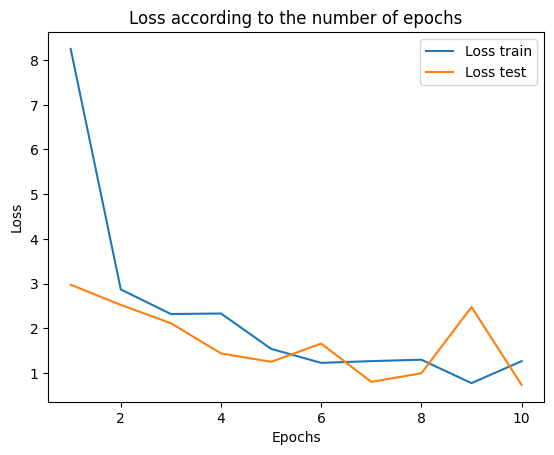

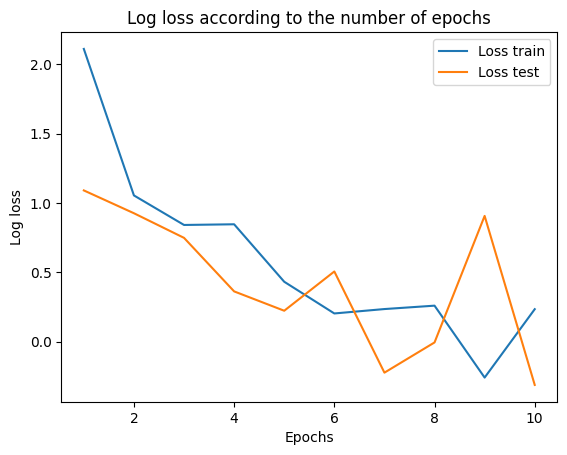

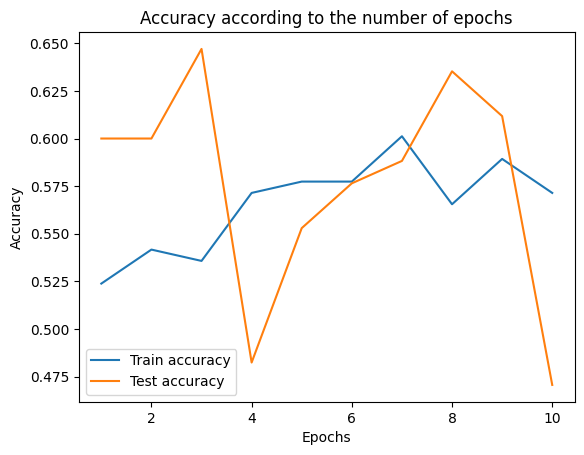

Confusion Matrix, Without Normalization


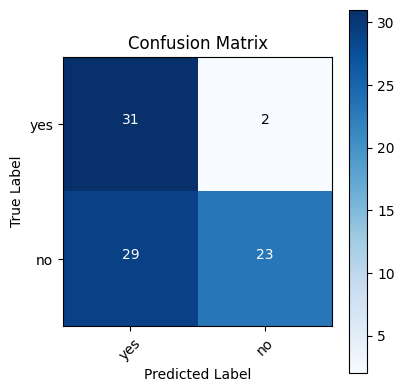

              precision    recall  f1-score   support

         yes       0.52      0.94      0.67        33
          no       0.92      0.44      0.60        52

    accuracy                           0.64        85
   macro avg       0.72      0.69      0.63        85
weighted avg       0.76      0.64      0.62        85



In [143]:
evaluation_plots(model_vgg19, test_loader, loss_train, acc_train, loss_test, acc_test)

### Results

In [144]:
results = {'Accuracy':[accuracy_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                       accuracy_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                       accuracy_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])],
           'Precision':[precision_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                       precision_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                       precision_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])],
           'Recall':[recall_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                     recall_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                     recall_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])],
           'F1-score':[f1_score(predict(model_vgg11, test_loader)[0],predict(model_vgg11, test_loader)[1]),
                     f1_score(predict(model_vgg16, test_loader)[0],predict(model_vgg16, test_loader)[1]),
                     f1_score(predict(model_vgg19, test_loader)[0],predict(model_vgg19, test_loader)[1])]}

vgg_result = pd.DataFrame(results, index=['VGG 11', 'VGG 16', 'VGG 19'])

results = pd.concat([eff_net_results, resnet_result, vgg_result], axis=0)

In [145]:
results

,Accuracy,Precision,Recall,F1-score
EfficientNet b0,0.788235,0.814815,0.846154,0.830189
EfficientNet b1,0.847059,0.882353,0.865385,0.873786
EfficientNet b2,0.764706,0.847826,0.750000,0.795918
EfficientNet b6,0.835294,0.865385,0.865385,0.865385
EfficientNet b7,0.858824,0.900000,0.865385,0.882353
Resnet34,0.811765,0.860000,0.826923,0.843137
Resnet50,0.588235,0.623188,0.826923,0.710744
Resnet152,0.741176,0.800000,0.769231,0.784314
VGG 11,0.623529,0.619048,1.000000,0.764706
VGG 16,0.694118,0.666667,1.000000,0.800000
